## Load Dependencies

In [1]:
import urllib.request
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from library import AutoEDA
from library import Explore

from library import create_windowed_df
from library import make_fourier
from library import harmonic_regression
from library import perform_pca
from library import biplot
from library import create_scree_plot
from library import find_optimal_K

In [2]:
# Convert the XML of the last 90 days of exchange rates from the ECB website to a pandas DataFrame

last_90 = "https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist-90d.xml?9531d63dc137832dc128c3fcc9bc4f12"

with urllib.request.urlopen(last_90) as response:
   xml_data = response.read()

root = ET.fromstring(xml_data)

df = pd.DataFrame(columns=['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF'],
                  dtype=np.dtype('float64'))
df.index = df.index.astype(np.dtype('datetime64[ns]'))

cube = root.find('{http://www.ecb.int/vocabulary/2002-08-01/eurofxref}Cube')

currencies_lst = ['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF']
dates = []
currencies_dict = {}

for child in cube:
    dates.append(child.attrib['time'])
    for rate_tag in child:
        currency = list(rate_tag.attrib.values())[0]
        rate = list(rate_tag.attrib.values())[1]
        if currency in currencies_lst:
            if currency in currencies_dict:
                currencies_dict[currency].append(rate)
            else:
                currencies_dict[currency] = [rate]

df = pd.DataFrame.from_dict(currencies_dict, dtype=np.dtype('float64'))
df['date'] = dates
df = df.set_index('date').rename_axis(None)
df.index = df.index.astype(np.dtype('datetime64[ns]'))

USD = df[['USD']]

df.head()

,USD,JPY,BGN,CZK,DKK,GBP,CHF
2024-04-05,1.0841,164.10,1.9558,25.286,7.4590,0.85773,0.9793
2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846
2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792
2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765
2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766


In [3]:
obj = AutoEDA(USD, 'USD')
dates_df = obj.append_datetime_cols()

In [4]:
dates_df

,USD,year,month,day,week_of_year,week_of_month,day_of_week
2024-04-05,1.0841,2024,4,5,14,1,5
2024-04-04,1.0852,2024,4,4,14,1,4
2024-04-03,1.0783,2024,4,3,14,1,3
2024-04-02,1.0749,2024,4,2,14,1,2
2024-03-28,1.0811,2024,3,28,13,4,4
...,...,...,...,...,...,...,...
2024-01-12,1.0942,2024,1,12,2,2,5
2024-01-11,1.0987,2024,1,11,2,2,4
2024-01-10,1.0946,2024,1,10,2,2,3
2024-01-09,1.0940,2024,1,9,2,2,2


In [5]:
fourier_df = make_fourier(dates_df, ['month', 'day', 'week_of_year', 'week_of_month', 'day_of_week'],2)
display(fourier_df.head())

,USD,year,month_sin1,month_cos1,month_sin2,month_cos2,day_sin1,day_cos1,day_sin2,day_cos2,...,week_of_year_sin2,week_of_year_cos2,week_of_month_sin1,week_of_month_cos1,week_of_month_sin2,week_of_month_cos2,day_of_week_sin1,day_of_week_cos1,day_of_week_sin2,day_of_week_cos2
2024-04-05,1.0841,2024,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,0.848644,0.528964,0.897805,-0.440394,...,-0.0,1.0,0.951057,0.309017,0.587785,-0.809017,-2.449294e-16,1.000000,-4.898587e-16,1.000000
2024-04-04,1.0852,2024,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,0.724793,0.688967,0.998717,-0.050649,...,-0.0,1.0,0.951057,0.309017,0.587785,-0.809017,-9.510565e-01,0.309017,-5.877853e-01,-0.809017
2024-04-03,1.0783,2024,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,0.571268,0.820763,0.937752,0.347305,...,-0.0,1.0,0.951057,0.309017,0.587785,-0.809017,-5.877853e-01,-0.809017,9.510565e-01,0.309017
2024-04-02,1.0749,2024,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,0.394356,0.918958,0.724793,0.688967,...,-0.0,1.0,0.951057,0.309017,0.587785,-0.809017,5.877853e-01,-0.809017,-9.510565e-01,0.309017
2024-03-28,1.0811,2024,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,-0.571268,0.820763,-0.937752,0.347305,...,-0.781831,0.62349,-0.951057,0.309017,-0.587785,-0.809017,-9.510565e-01,0.309017,-5.877853e-01,-0.809017


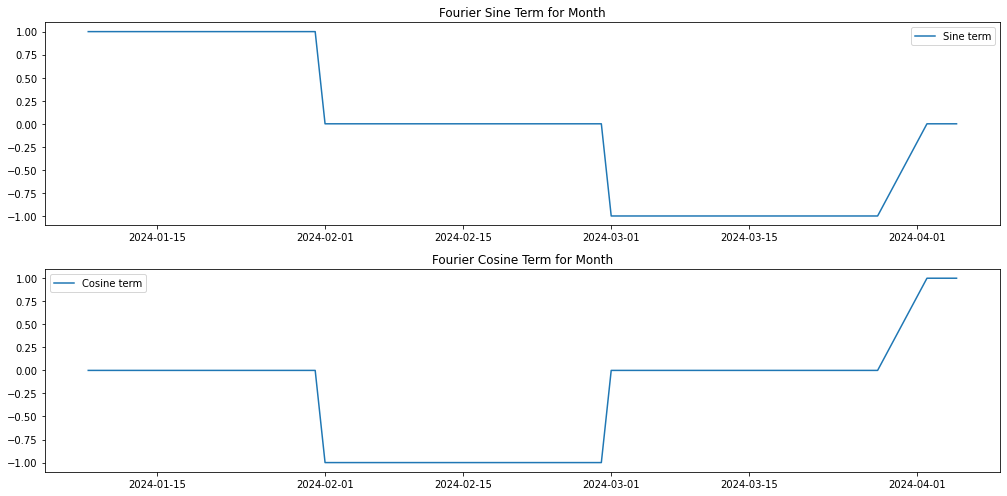

In [6]:


# Plot the Fourier terms
plt.figure(figsize=(14, 7))

# Plot the sine term
plt.subplot(2, 1, 1)
plt.plot(fourier_df.index, fourier_df['month_sin1'], label='Sine term')
plt.title('Fourier Sine Term for Month')
plt.legend()

# Plot the cosine term
plt.subplot(2, 1, 2)
plt.plot(fourier_df.index, fourier_df['month_cos1'], label='Cosine term')
plt.title('Fourier Cosine Term for Month')
plt.legend()

plt.tight_layout()
plt.show()

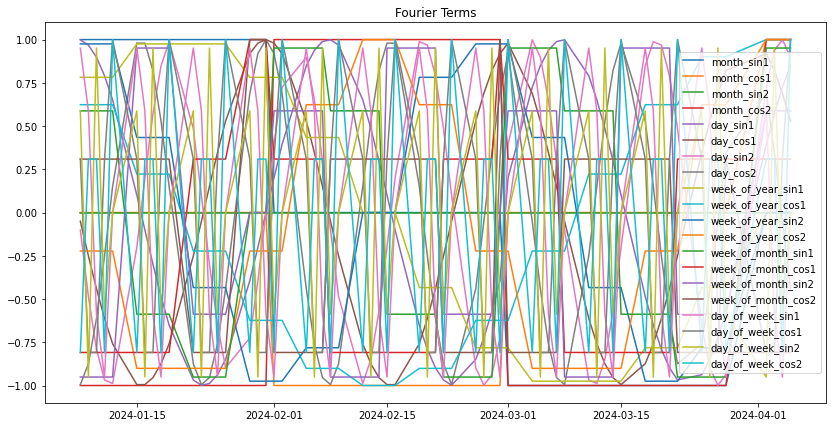

In [7]:
plt.figure(figsize=(14, 7))

# Assuming you have sine and cosine terms for multiple frequencies (e.g., month, day, etc.)
for col in fourier_df.columns:
    if 'sin' in col or 'cos' in col:
        plt.plot(fourier_df.index, fourier_df[col], label=col)

plt.title('Fourier Terms')
plt.legend()
plt.show()


### Harmonic Regression

In [8]:
optimal_K, optimal_model, df_with_preds = find_optimal_K(dates_df, 'USD', 10)

Predictor Variance:
month_sin1    6.118792e-01
month_cos1    3.292371e-01
month_sin2    8.216042e-32
month_cos2    9.728623e-01
dtype: float64
K: 1, AIC: -501.0246923721194
Predictor Variance:
month_sin1    6.118792e-01
month_cos1    3.292371e-01
month_sin2    8.216042e-32
month_cos2    9.728623e-01
dtype: float64
K: 2, AIC: -501.0246923721194
Predictor Variance:
month_sin1    6.118792e-01
month_cos1    3.292371e-01
month_sin2    8.216042e-32
month_cos2    9.728623e-01
dtype: float64
K: 3, AIC: -501.0246923721194
Predictor Variance:
month_sin1    6.118792e-01
month_cos1    3.292371e-01
month_sin2    8.216042e-32
month_cos2    9.728623e-01
dtype: float64
K: 4, AIC: -501.0246923721194
Predictor Variance:
month_sin1    6.118792e-01
month_cos1    3.292371e-01
month_sin2    8.216042e-32
month_cos2    9.728623e-01
dtype: float64
K: 5, AIC: -501.0246923721194
Predictor Variance:
month_sin1    6.118792e-01
month_cos1    3.292371e-01
month_sin2    8.216042e-32
month_cos2    9.728623e-01
dtype: 

In [9]:
optimal_K


1

In [10]:
optimal_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    USD   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     21.20
Date:                Sat, 06 Apr 2024   Prob (F-statistic):           1.93e-09
Time:                        03:21:23   Log-Likelihood:                 254.51
No. Observations:                  63   AIC:                            -501.0
Df Residuals:                      59   BIC:                            -492.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0843      0.001   1552.188      0.000       1.083       1.086
month_sin1     0.0013      0.001      1.805      0.076      -0.000       0.003
month_cos1     0.0006      0.001      0.481      0.633      -0.002       0.003
month_sin2 -7.485e-18   1.65e-18     -4.539      0.000   -1.08e-17   -4.19e-18
month_cos2    -0.0042      0.001     -6.057      0.000      -0.006      -0.003
==============================================================================
Omnibus:                        6.959   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                2.711
Skew:                           0.140   Prob(JB):                        0.258
Kurtosis:                       2.023   Cond. No.                     1.39e+31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.92e-61. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [10]:
# Display the head of the DataFrame with predictions
df_with_preds.iloc[21:41]


,USD,year,month,day,week_of_year,week_of_month,day_of_week,month_sin1,month_cos1,month_sin2,month_cos2,harmonic_pred
2024-03-05,1.0849,2024,3,5,10,1,2,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-03-04,1.0846,2024,3,4,10,1,1,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-03-01,1.0813,2024,3,1,9,1,5,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-02-29,1.0826,2024,2,29,9,5,4,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.079471
2024-02-28,1.0808,2024,2,28,9,4,3,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.079471
2024-02-27,1.0856,2024,2,27,9,4,2,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.079471
2024-02-26,1.0852,2024,2,26,9,4,1,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.079471
2024-02-23,1.0834,2024,2,23,8,4,5,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.079471
2024-02-22,1.0844,2024,2,22,8,4,4,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.079471
2024-02-21,1.0809,2024,2,21,8,3,3,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.079471


In [11]:
df_with_preds.head(10)


,USD,year,month,day,week_of_year,week_of_month,day_of_week,month_sin1,month_cos1,month_sin2,month_cos2,harmonic_pred
2024-04-05,1.0841,2024,4,5,14,1,5,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,1.080625
2024-04-04,1.0852,2024,4,4,14,1,4,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,1.080625
2024-04-03,1.0783,2024,4,3,14,1,3,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,1.080625
2024-04-02,1.0749,2024,4,2,14,1,2,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,1.080625
2024-03-28,1.0811,2024,3,28,13,4,4,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-03-27,1.0816,2024,3,27,13,4,3,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-03-26,1.0855,2024,3,26,13,4,2,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-03-25,1.0835,2024,3,25,13,4,1,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-03-22,1.0823,2024,3,22,12,4,5,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220
2024-03-21,1.0907,2024,3,21,12,3,4,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.087220


In [12]:
df_with_preds.tail(10)

,USD,year,month,day,week_of_year,week_of_month,day_of_week,month_sin1,month_cos1,month_sin2,month_cos2,harmonic_pred
2024-01-19,1.0887,2024,1,19,3,3,5,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-18,1.0875,2024,1,18,3,3,4,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-17,1.0877,2024,1,17,3,3,3,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-16,1.0882,2024,1,16,3,3,2,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-15,1.0945,2024,1,15,3,3,1,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-12,1.0942,2024,1,12,2,2,5,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-11,1.0987,2024,1,11,2,2,4,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-10,1.0946,2024,1,10,2,2,3,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-09,1.0940,2024,1,9,2,2,2,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898
2024-01-08,1.0946,2024,1,8,2,2,1,1.0,6.123234e-17,1.224647e-16,-1.0,1.0898


In [12]:
# see https://www.youtube.com/watch?v=S_Z8RnTE5dI ~52:00 minute mark

eleven_window = create_windowed_df(USD, 10, 'USD')
display(eleven_window.head(11))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = eleven_window.drop('USD', axis=1)  
y = eleven_window['USD']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

predictions = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

,USD_t-10,USD_t-9,USD_t-8,USD_t-7,USD_t-6,USD_t-5,USD_t-4,USD_t-3,USD_t-2,USD_t-1,USD
2024-01-22,1.0946,1.0940,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890
2024-01-23,1.0940,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872
2024-01-24,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905
2024-01-25,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893
2024-01-26,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871
2024-01-29,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823
2024-01-30,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846
2024-01-31,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837
2024-02-01,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837,1.0814
2024-02-02,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837,1.0814,1.0883


Mean Squared Error: 2.0678955000002172e-05


## Data Augmentation

In [11]:
#Extracting Spy closing prices into dataframe

spy = yf.Ticker("SPY")
spy_hist = spy.history(period="6mo")
spy_hist = spy_hist[['Close']]
spy_hist.index = spy_hist.index.date
spy_hist

c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Close
2023-10-06,426.480408
2023-10-09,429.210815
2023-10-10,431.444794
2023-10-11,433.212128
2023-10-12,430.571075
...,...
2024-04-01,522.159973
2024-04-02,518.840027
2024-04-03,519.409973
2024-04-04,513.070007


In [12]:
#Performing Data Augmentation and Merging
df_augmented = pd.merge(df, spy_hist, left_index=True, right_index=True, how='left')
df_augmented = df_augmented.dropna()
df_augmented

,USD,JPY,BGN,CZK,DKK,GBP,CHF,Close
2024-04-05,1.0841,164.10,1.9558,25.286,7.4590,0.85773,0.9793,518.429993
2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846,513.070007
2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792,519.409973
2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765,518.840027
2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766,523.070007
...,...,...,...,...,...,...,...,...
2024-01-12,1.0942,159.17,1.9558,24.689,7.4565,0.85950,0.9350,475.203522
2024-01-11,1.0987,159.71,1.9558,24.659,7.4568,0.86145,0.9338,474.874542
2024-01-10,1.0946,159.03,1.9558,24.562,7.4582,0.86023,0.9336,475.083893
2024-01-09,1.0940,157.63,1.9558,24.594,7.4577,0.85938,0.9313,472.412201


<Axes: >

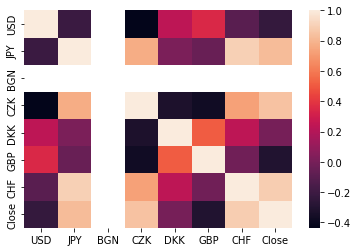

In [13]:
corr = df_augmented.corr()
sns.heatmap(corr)



## Principal Component Analysis

In [14]:
# Perform PCA on the exchange rate data
pca, pc_df = perform_pca(df_augmented, n_components=None)

## PCA Biplot

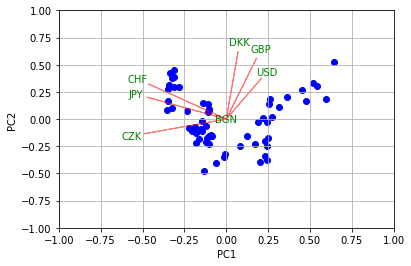

In [15]:
# Assuming `pc_df` is the DataFrame of principal components
# and `pca` is your PCA object after fitting the data
biplot(pc_df.values[:, :2], np.transpose(pca.components_[0:2, :]), labels=df.columns.values[:pca.components_.shape[1]])
plt.show()


## Scree Plot

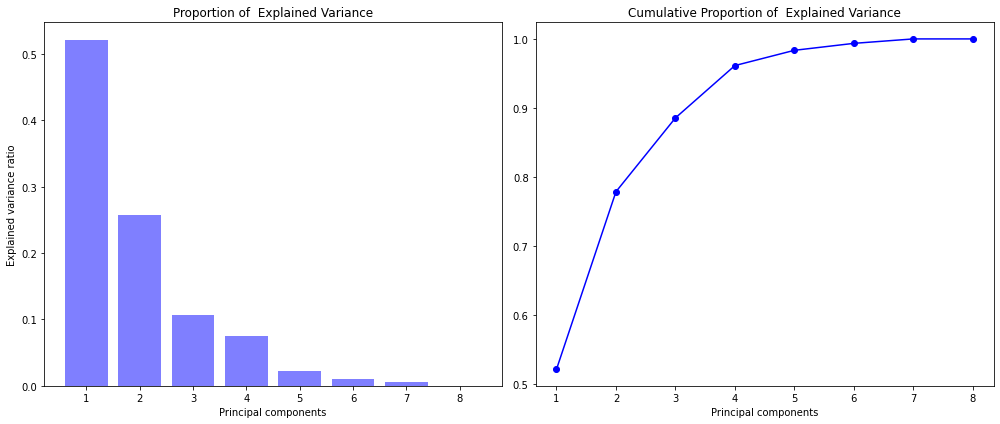

In [16]:
# Create a scree plot to visualize the explained variance
create_scree_plot(pca)

## Interactive plots using Plotly

In [17]:
import plotly.express as px

In [18]:
df

,USD,JPY,BGN,CZK,DKK,GBP,CHF
2024-04-05,1.0841,164.10,1.9558,25.286,7.4590,0.85773,0.9793
2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846
2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792
2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765
2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766
...,...,...,...,...,...,...,...
2024-01-12,1.0942,159.17,1.9558,24.689,7.4565,0.85950,0.9350
2024-01-11,1.0987,159.71,1.9558,24.659,7.4568,0.86145,0.9338
2024-01-10,1.0946,159.03,1.9558,24.562,7.4582,0.86023,0.9336
2024-01-09,1.0940,157.63,1.9558,24.594,7.4577,0.85938,0.9313


In [24]:
import plotly.express as px
import pandas as pd

df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

# First, filter out only the desired currencies.
filtered_df = df[['Date', 'USD', 'BGN', 'GBP', 'CHF']]

# Melt the filtered DataFrame to format it for Plotly Express.
df_melted = filtered_df.melt(id_vars='Date', var_name='Currency', value_name='Value')
# Ensure the dates are sorted

In [33]:
# Ensure the dates are sorted
df_melted.sort_values('Date', inplace=True)

In [25]:
filtered_df

,Date,USD,BGN,GBP,CHF
0,2024-04-05,1.0841,1.9558,0.85773,0.9793
1,2024-04-04,1.0852,1.9558,0.85788,0.9846
2,2024-04-03,1.0783,1.9558,0.85713,0.9792
3,2024-04-02,1.0749,1.9558,0.85510,0.9765
4,2024-03-28,1.0811,1.9558,0.85510,0.9766
...,...,...,...,...,...
58,2024-01-12,1.0942,1.9558,0.85950,0.9350
59,2024-01-11,1.0987,1.9558,0.86145,0.9338
60,2024-01-10,1.0946,1.9558,0.86023,0.9336
61,2024-01-09,1.0940,1.9558,0.85938,0.9313


In [34]:
df_melted

,Date,Currency,Value
125,2024-01-08,BGN,1.95580
188,2024-01-08,GBP,0.86150
62,2024-01-08,USD,1.09460
251,2024-01-08,CHF,0.93080
61,2024-01-09,USD,1.09400
...,...,...,...
190,2024-04-04,CHF,0.98460
189,2024-04-05,CHF,0.97930
126,2024-04-05,GBP,0.85773
63,2024-04-05,BGN,1.95580


In [36]:
import plotly.graph_objs as go

In [46]:


# Assuming 'filtered_df' is your DataFrame and has been properly formatted with 'Date' as a column

# Create an empty figure object
fig = go.Figure()

# Function to add traces to the figure
def add_currency_trace(fig, df, currency_name, color):
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df[currency_name],
            name=currency_name,
            mode='lines+markers',
            line=dict(color=color),
            marker=dict(size=10, opacity=0.8, line=dict(width=2)),
            hoverinfo='x+y'
        )
    )

# Add traces for each currency
add_currency_trace(fig, filtered_df, 'USD', 'blue')
add_currency_trace(fig, filtered_df, 'BGN', 'green')
add_currency_trace(fig, filtered_df, 'GBP', 'red')
add_currency_trace(fig, filtered_df, 'CHF', 'orange')

# Set the range of y-axis
fig.update_layout(yaxis_range=[0, 2])

# Update the layout
fig.update_layout(
    title='Currency Exchange Rates Over Time',
    xaxis_title='Date',
    yaxis_title='Value in Euro',
    hovermode='x unified', # 'x unified' will show the tooltip for all traces at the same x location
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),# Position the legend
    width=1000,
    height=600
)

# Customize the layout of the plot to fit the data and remove irrelevant buttons
max_date = filtered_df['Date'].max()  # Assuming 'Date' is a datetime column
min_date = max_date - pd.Timedelta(days=90)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward', visible=max_date >= min_date + pd.Timedelta(days=30)),
                dict(count=3, label='3m', step='month', stepmode='backward', visible=max_date >= min_date + pd.Timedelta(days=90)),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type='date',
        range=[min_date, max_date]  # Set the range of x-axis to the last 90 days
    )
)

# Show figure
fig.show()


In [49]:


# Assuming 'filtered_df' is your DataFrame and has been properly formatted with 'Date' as a column

# Create an empty figure object
fig = go.Figure()

# Function to add traces to the figure
def add_currency_trace(fig, df, currency_name, color):
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df[currency_name],
            name=currency_name,
            mode='lines+markers',
            line=dict(color=color),
            marker=dict(size=10, opacity=0.8, line=dict(width=2)),
            hoverinfo='x+y'
        )
    )

# Add traces for each currency
add_currency_trace(fig, filtered_df, 'USD', 'blue')
add_currency_trace(fig, filtered_df, 'BGN', 'green')
add_currency_trace(fig, filtered_df, 'GBP', 'red')
add_currency_trace(fig, filtered_df, 'CHF', 'orange')

# Set the range of y-axis
fig.update_layout(yaxis_range=[0, 2])

# Update the layout with the desired figure size and adjust layout parameters
fig.update_layout(
    title='Currency Exchange Rates Over Time',
    xaxis_title='Date',
    yaxis_title='Value in Euro',
    hovermode='x unified',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width=1200,  # Updated width
    height=600   # Updated height
)

# Customize the range slider and buttons to fit the 90 days range
max_date = filtered_df['Date'].max()  # Assuming 'Date' is a datetime column
min_date = max_date - pd.Timedelta(days=90)



# If necessary, adjust marker sizes directly in the trace definitions.
for trace in fig.data:
    trace['marker']['size'] = 15  # Update the size of markers if needed

# Show the plot
fig.show()